In [1]:
#import geopandas as gpd
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import plotly.express as px

## Collection events

In [2]:
#waste_aust = pd.read_csv(r'C:\Users\fredericorodrigues\Downloads\waste_collection.csv')  
#waste_aust = pd.read_csv('waste_collection.csv')  
waste_aust = pd.read_csv('data/waste.csv')  

In [3]:
waste_aust.dtypes

Report Date      object
Load Type        object
Load Time        object
Load Weight     float64
Dropoff Site     object
Route Type       object
Route Number     object
Load ID           int64
dtype: object

## Data Processing

In [4]:
waste_aust['Load Time'] = pd.to_datetime(waste_aust['Load Time'])
cal = calendar()
holidays = cal.holidays(start=waste_aust['Load Time'].min(), end=waste_aust['Load Time'].max())

waste_aust['Holiday'] = waste_aust['Load Time'].isin(holidays)
waste_aust['DoW'] = waste_aust['Load Time'].dt.day_name()

In [5]:
waste_aust.head()

Report Date                  Load Type           Load Time  Load Weight  \
0  12/08/2020                       BULK 2020-12-08 15:02:00       5220.0   
1  12/08/2020  RECYCLING - SINGLE STREAM 2020-12-08 10:00:00      11140.0   
2  12/03/2020  RECYCLING - SINGLE STREAM 2020-12-03 10:34:00      10060.0   
3  12/07/2020                   SWEEPING 2020-12-07 10:15:00       7100.0   
4  12/07/2020  RECYCLING - SINGLE STREAM 2020-12-07 16:00:00      12000.0   

         Dropoff Site                 Route Type Route Number  Load ID  \
0        TDS LANDFILL                       BULK         BU13   899097   
1           TDS - MRF  RECYCLING - SINGLE STREAM       RTAU53   899078   
2  BALCONES RECYCLING  RECYCLING - SINGLE STREAM       RHBU10   899082   
3        TDS LANDFILL          SWEEPER DUMPSITES        DSS04   899030   
4           TDS - MRF  RECYCLING - SINGLE STREAM       RMAU53   899048   

   Holiday       DoW  
0    False   Tuesday  
1    False   Tuesday  
2    False  Thursday  
3    False    Monday  
4    False    Monday

In [6]:
waste_aust.groupby('Route Number')['Load ID'].nunique()

Route Number
0BM00            69
0F16              6
ABR01             3
AFD-FIREWISE     31
BKR-BR            9
               ... 
YW12            297
YW13             59
YWNONGS           3
YWNONVA          31
ZILKER           52
Name: Load ID, Length: 2221, dtype: int64

In [8]:
waste_aust_2019 = waste_aust.loc[(waste_aust['Load Time'] >= '2019-01-01')
                     & (waste_aust['Load Time'] < '2020-01-01')]
waste_aust_2019 = waste_aust_2019.set_index(['Load Time'])
waste_aust_2019 = waste_aust_2019.sort_index()

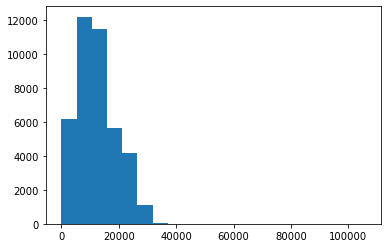

In [9]:
# Weight histogram
plt.hist(waste_aust_2019['Load Weight'], bins = 20)
plt.show()

<AxesSubplot:>

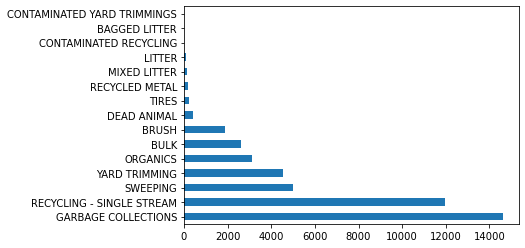

In [10]:
# Load Type countplot
waste_aust_2019['Load Type'].value_counts().plot(kind='barh')

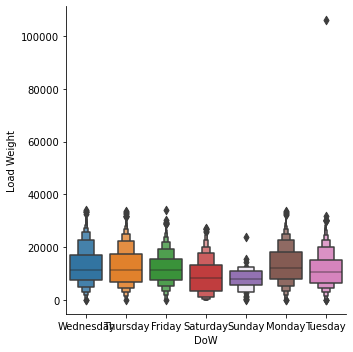

In [11]:
sns.catplot(x="DoW", y="Load Weight", kind="boxen",
            data=waste_aust_2019)

## Waste Routes

In [12]:
waste_aust[(waste_aust['Load Time']>'2019-01-01')]['Route Type'].drop_duplicates()

0                                     BULK
1                RECYCLING - SINGLE STREAM
3                        SWEEPER DUMPSITES
5                       GARBAGE COLLECTION
12                          YARD TRIMMINGS
13                                   BRUSH
39                 YARD TRIMMINGS-ORGANICS
91                    STREET CLEANING-BLVD
110                           ON CALL BULK
126                         LITTER CONTROL
148                                    KAB
172       STREET CLEANING-SPECIAL PROJECTS
241                            DEAD ANIMAL
561                     SPECIAL PROJECT LC
999            STREET CLEANING-RESIDENTIAL
1136                   INHOUSE - RECYCLING
1888                    RECYCLING DEAD END
3049                    SPECIAL PROJECT BU
3713              STREET CLEANING-DOWNTOWN
5774                        SPECIAL EVENTS
6173                  STREET CLEANING-SXSW
7575                                 STORM
11878                             CAP BULK
17025      

In [13]:
bulk_routes = waste_aust[(waste_aust['Load Time']>'2019-01-01')&(waste_aust['Route Number'].astype(str).str[:2] == 'BU')]['Route Number'].drop_duplicates().to_list()

In [14]:
bulky_waste_routes = gpd.read_file('BOUNDARIES_bulky_collection_routes.geojson')
bulky_waste_routes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   last_service_date  22 non-null     object  
 1   created_by         24 non-null     object  
 2   shape_area         24 non-null     object  
 3   area_supervisor    24 non-null     object  
 4   created_date       24 non-null     object  
 5   next_service_date  22 non-null     object  
 6   objectid           24 non-null     object  
 7   route_name         24 non-null     object  
 8   shape_leng         24 non-null     object  
 9   shape_length       24 non-null     object  
 10  modified_by        24 non-null     object  
 11  modified_date      24 non-null     object  
 12  primary_key        24 non-null     object  
 13  geometry           24 non-null     geometry
dtypes: geometry(1), object(13)
memory usage: 2.8+ KB


In [15]:
waste_aust[(waste_aust['Load Time']>'2019-01-01')&(waste_aust['Route Number'].astype(str).str[:2] == 'BU')]['Route Number'].drop_duplicates().count()

23

In [16]:
bulky_waste_routes[bulky_waste_routes['route_name'].isin(bulk_routes)]['route_name'].drop_duplicates().count()

22

In [17]:
Garbage_waste_routes = gpd.read_file('BOUNDARIES_garbage_collection_routes_data.geojson')
Garbage_waste_routes.head()

created_by        shape_area area_supervisor         created_date  \
0  Zimmerman  39141325.0234375  Chris Guerrero  2007-10-01T00:00:00   
1  Zimmerman  29740260.9316406  Chris Guerrero  2007-10-01T00:00:00   
2  Zimmerman   19996083.765625   Patrick Clark  2007-10-01T00:00:00   
3  Zimmerman  16850216.9121094   Amos Castillo  2007-10-01T00:00:00   
4  Zimmerman  27286934.0078125  Corey Anderson  2007-10-01T00:00:00   

  objectid_1 operational_truck_type landfill_site objectid route_name  \
0         81                   Auto           TDS       98      PAF63   
1         12                   Auto           TDS       14      PAM63   
2         36                   Semi           TDS       41       PM22   
3         96                   Auto           TDS      117      PAH51   
4         63                   Semi           TDS       76       PF33   

       shape_length modified_by service_day        modified_date primary_key  \
0  37605.2279134456   Zimmerman      Friday  2020-12-01T00:00:00          87   
1  29034.8774060973   Zimmerman      Monday  2020-12-15T00:00:00          12   
2    26936.17097646   Zimmerman      Monday  2020-09-10T00:00:00          38   
3  18394.2058396516   Zimmerman    Thursday  2021-01-14T00:00:00         102   
4  21797.2967924316   Zimmerman      Friday  2021-01-20T00:00:00          68   

  supervisor_id_number                                           geometry  
0                  170  MULTIPOLYGON (((-97.72688 30.32638, -97.72664 ...  
1                  170  MULTIPOLYGON (((-97.86484 30.23404, -97.86447 ...  
2                  200  MULTIPOLYGON (((-97.79000 30.19365, -97.79005 ...  
3                  500  MULTIPOLYGON (((-97.67327 30.31422, -97.67185 ...  
4                  643  MULTIPOLYGON (((-97.76183 30.28456, -97.76038 ...

In [18]:
waste_aust[waste_aust['Route Type']=='GARBAGE COLLECTION']['Route Number'].drop_duplicates().count()

436

In [19]:
garbage_routes = Garbage_waste_routes['route_name'].drop_duplicates().to_list()

In [20]:
waste_aust[(waste_aust['Load Time']>'2019-01-01')&(waste_aust['Route Type']=='GARBAGE COLLECTION')]['Route Number'].drop_duplicates().count()

308

In [21]:
waste_aust[(waste_aust['Route Number'].isin(garbage_routes))]['Route Number'].drop_duplicates().count()

185

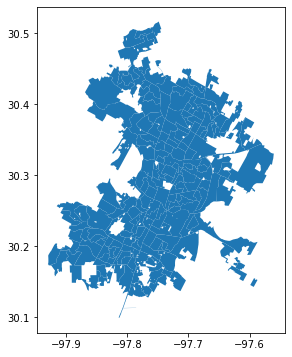

In [22]:
Garbage_waste_routes.plot(figsize=(6, 6))
plt.show()

In [23]:
m = folium.Map(location=[30.30, -97.7], zoom_start=10, tiles='CartoDB positron')

for _, r in Garbage_waste_routes.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['geometry']).add_to(geo_j)
    geo_j.add_to(m)
m

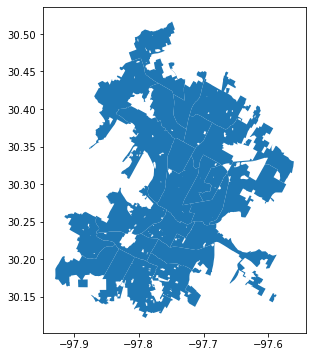

In [24]:
bulky_waste_routes.plot(figsize=(6, 6))
plt.show()

In [25]:
m = folium.Map(location=[30.30, -97.7], zoom_start=10, tiles='CartoDB positron')

for _, r in bulky_waste_routes.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['geometry']).add_to(geo_j)
    geo_j.add_to(m)
m

In [26]:
aaa = waste_aust['Load Time'].max()
waste_aust[waste_aust['Load Time']>'2021-12-31']

Report Date    Load Type           Load Time  Load Weight  \
352538  11/24/2020  DEAD ANIMAL 2030-11-24 13:49:00        320.0   
730958  07/29/2020  DEAD ANIMAL 2030-07-29 14:08:00        260.0   

        Dropoff Site   Route Type Route Number  Load ID  Holiday     DoW  
352538  TDS LANDFILL  DEAD ANIMAL         DA02   897529    False  Sunday  
730958  TDS LANDFILL  DEAD ANIMAL         DA01   883665    False  Monday

In [28]:
waste_aust[(waste_aust['Load Time']>'2019-01-01')]['Route Type'].drop_duplicates()

0                                     BULK
1                RECYCLING - SINGLE STREAM
3                        SWEEPER DUMPSITES
5                       GARBAGE COLLECTION
12                          YARD TRIMMINGS
13                                   BRUSH
39                 YARD TRIMMINGS-ORGANICS
91                    STREET CLEANING-BLVD
110                           ON CALL BULK
126                         LITTER CONTROL
148                                    KAB
172       STREET CLEANING-SPECIAL PROJECTS
241                            DEAD ANIMAL
561                     SPECIAL PROJECT LC
999            STREET CLEANING-RESIDENTIAL
1136                   INHOUSE - RECYCLING
1888                    RECYCLING DEAD END
3049                    SPECIAL PROJECT BU
3713              STREET CLEANING-DOWNTOWN
5774                        SPECIAL EVENTS
6173                  STREET CLEANING-SXSW
7575                                 STORM
11878                             CAP BULK
17025      

In [29]:
df = waste_aust[waste_aust['Route Type']=='BULK'].copy()

In [30]:
df['week'] = pd.to_datetime(df['Load Time'], format='%Y-%m-%d').dt.isocalendar().week
df['year'] = pd.to_datetime(df['Load Time'], format='%Y-%m-%d').dt.isocalendar().year

In [31]:
df['aggregate_week'] = pd.to_datetime(df.year.astype(str), format='%Y') + \
pd.to_timedelta(df.week.mul(7).astype(str) + ' days')

In [32]:
weekly=df.groupby('aggregate_week')['Load Weight'].sum()

In [33]:
weekly

aggregate_week
2001-03-19      8980.0
2001-10-22     22340.0
2004-01-15      8560.0
2004-10-07     11000.0
2004-10-14    368057.0
                ...   
2021-06-11    478300.0
2021-06-18    605900.0
2021-06-25    335480.0
2021-07-02    770280.0
2021-07-09    605160.0
Name: Load Weight, Length: 824, dtype: float64

In [34]:
fig = px.line(x=weekly.index, y=weekly, labels={'x':'Date', 'y':'Units'})
fig.show()

In [38]:
waste_aust.groupby(['Route Number','Dropoff Site']).sum()

Load Weight   Load ID  Holiday
Route Number Dropoff Site                                    
0BM00        HORNSBY BEND          20200.0   3030136        0
             ORGANICS BY GOSH     365060.0  53016434        0
             TDS LANDFILL          16640.0   1615523        0
0F16         ORGANICS BY GOSH      49200.0   5287102        0
ABR01        TDS LANDFILL          40820.0    373035        0
...                                    ...       ...      ...
YWNONGS      HORNSBY BEND           8330.0   1447801        0
YWNONVA      BRAKER SITE          181500.0   8026910        0
             HORNSBY BEND         227000.0  13562278        0
ZILKER       HORNSBY BEND         310120.0   4497125        0
             STEINER LANDFILL     511600.0   8839760        0

[6161 rows x 3 columns]

In [43]:
waste_aust[(waste_aust['Route Number']=='BU13')].sort_values('Report Date')

Report Date Load Type           Load Time  Load Weight  \
403730  01/18/2005      BULK 2005-01-18 13:14:00      12740.0   
426077  01/18/2005      BULK 2005-01-18 12:29:00       2480.0   
221653  01/18/2005      BULK 2005-01-18 12:50:00      10480.0   
214624  01/18/2005      BULK 2005-01-18 08:02:00       3900.0   
110494  01/18/2005      BULK 2005-01-18 09:57:00      12880.0   
...            ...       ...                 ...          ...   
524042  12/14/2017      BULK 2017-12-14 00:00:00       4820.0   
518083  12/14/2017      BULK 2017-12-14 00:00:00      10800.0   
511634  12/14/2017      BULK 2017-12-14 00:00:00      11000.0   
577568  12/14/2017      BULK 2017-12-14 00:00:00      11620.0   
128527  12/14/2017      BULK 2017-12-14 00:00:00      10300.0   

            Dropoff Site Route Type Route Number  Load ID  Holiday       DoW  
403730      TDS LANDFILL       BULK         BU13   115363    False   Tuesday  
426077  STEINER LANDFILL       BULK         BU13   115373    False   Tuesday  
221653      TDS LANDFILL       BULK         BU13   115361    False   Tuesday  
214624  STEINER LANDFILL       BULK         BU13   115371    False   Tuesday  
110494      TDS LANDFILL       BULK         BU13   115362    False   Tuesday  
...                  ...        ...          ...      ...      ...       ...  
524042      TDS LANDFILL       BULK         BU13   764524    False  Thursday  
518083      TDS LANDFILL       BULK         BU13   764522    False  Thursday  
511634      TDS LANDFILL       BULK         BU13   764540    False  Thursday  
577568      TDS LANDFILL       BULK         BU13   764535    False  Thursday  
128527      TDS LANDFILL       BULK         BU13   764526    False  Thursday  

[2667 rows x 10 columns]